<a href="https://colab.research.google.com/github/shafieiali42/FreeRAD/blob/main/MVTec_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/ipythonx/mvtec-ad?resource=download

In [ ]:
! pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "shafieiali666"
os.environ['KAGGLE_KEY'] = "2a72371e7748b1c2a39075b67b207030"

In [ ]:
!kaggle datasets download -d ipythonx/mvtec-ad

100% 4.90G/4.91G [00:59<00:00, 137MB/s]
100% 4.91G/4.91G [01:00<00:00, 87.6MB/s]


In [ ]:
! unzip -q mvtec-ad.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

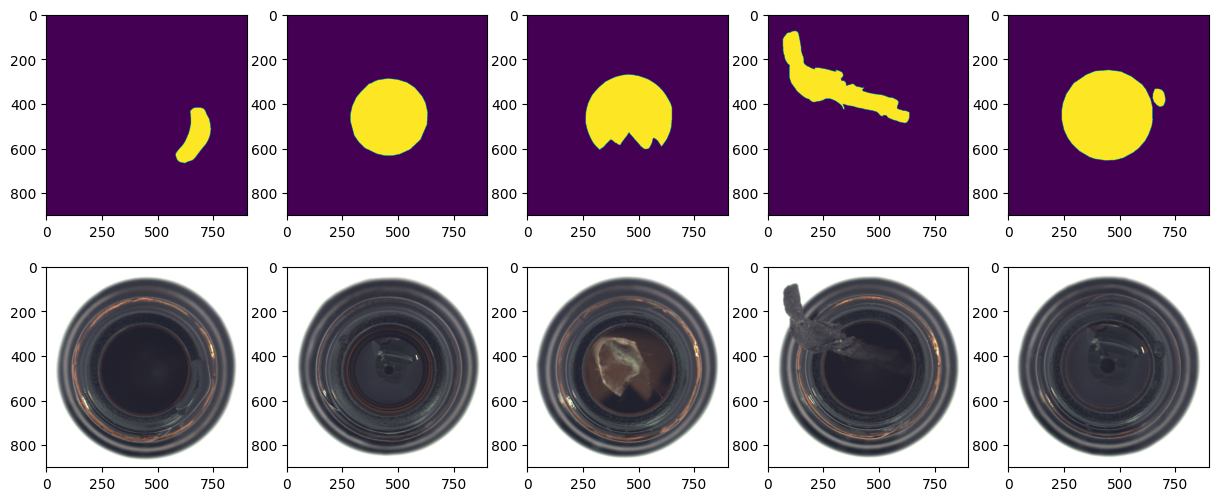

In [ ]:
ground_truth_entries = os.listdir('bottle/ground_truth/contamination/')
test_entries = [name[:3] for name in ground_truth_entries ]
indexes=random.sample(range(len(ground_truth_entries)), 5)
fig,axs=plt.subplots(2,5,figsize=(15,6))
counter=0
while counter<len(indexes):
  axs[0,counter%5].imshow(plt.imread(f"bottle/ground_truth/contamination/{ground_truth_entries[indexes[counter]]}"))
  axs[1,counter%5].imshow(plt.imread(f"bottle/test/contamination/{test_entries[indexes[counter]]}.png"))
  counter+=1

## Anomaly score Algorithm

In [ ]:
def anomaly_score_calculation(image,reconstructed,mean_error_maps_of_traing=None,chanel_axis=2,mean_filter_size=3):
  image=image.copy()
  reconstructed=reconstructed.copy()
  image = image.astype("float64")
  reconstructed = reconstructed.astype("float64")
  scales=[1,0.5,0.25,0.125]
  error_maps=[]
  for scale in scales:
    resized_image = cv2.resize(image, None, fx = scale, fy = scale)
    resized_reconstructed = cv2.resize(reconstructed, None, fx = scale, fy = scale)
    diff=(resized_image-resized_reconstructed)**2
    err_l=np.mean(diff,axis=chanel_axis)
    err_l=cv2.resize(err_l,(image.shape[1],image.shape[0]))
    error_maps.append(err_l)
  mean_err_map=np.zeros_like(error_maps[0])
  for i in range(len(error_maps)):
    mean_err_map=mean_err_map+error_maps[i]/len(error_maps)
  filter=np.ones((mean_filter_size,mean_filter_size),dtype="float64")/(mean_filter_size**2)
  mean_err_map=cv2.filter2D(mean_err_map,-1,filter,borderType=cv2.BORDER_CONSTANT)

  plt.imshow(mean_err_map,cmap="gray")




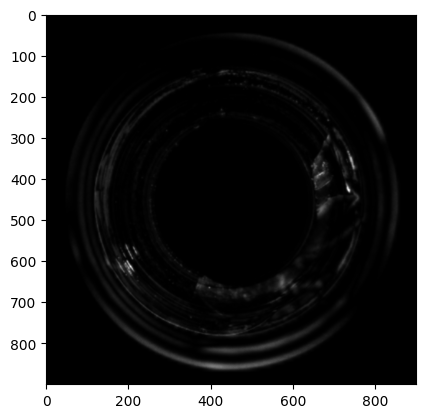

In [ ]:
image=plt.imread(f"bottle/test/broken_large/000.png")
reconstructed=plt.imread(f"bottle/test/good/000.png")
anomaly_score_calculation(image,reconstructed)

In [ ]:
categories=["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]
for category in categories:
  entries = os.listdir(f'{category}/train/good/')
  print(f"{category}: {len(entries)}")



bottle: 209
cable: 224
capsule: 219
carpet: 280
grid: 264
hazelnut: 391
leather: 245
metal_nut: 220
pill: 267
screw: 320
tile: 230
toothbrush: 60
transistor: 213
wood: 247
zipper: 240


## Dataset and DataLoader

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,image_paths,transform=None):
      self.image_paths=image_paths
      self.transform=transform

    def __getitem__(self, index):
      image=cv2.imread(self.image_paths[index])
      if self.transform is not None:
        image=self.transform(image)
      return image

    def __len__(self):
      return len(self.image_paths)

In [ ]:
entries = os.listdir("carpet/train/good/") # 1024 * 1024
carpet_image_paths=["carpet/train/good/"+image_name for image_name in entries]
image_size=500
my_carpet_transforms=transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])
carpet_train_dataset = ImageDataset(carpet_image_paths,my_carpet_transforms)
train_loader = DataLoader(dataset=carpet_train_dataset,batch_size=64,shuffle=True)